In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from sklearn.metrics import confusion_matrix
import itertools
import sklearn 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
data_dir = '/content/drive/My Drive/Malaria Cells Dataset'

In [119]:
#Define transforms for the training data and testing data
train_transforms = transforms.Compose([#transforms.RandomRotation(30),
                                       #transforms.RandomResizedCrop(224),
                                       #transforms.RandomHorizontalFlip(),
                                       transforms.Resize(256),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

valid_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

In [122]:
#pass transform here-in
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=train_transforms)
validation_data = datasets.ImageFolder(data_dir + '/val', transform=valid_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True, num_workers=8, pin_memory=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=16, shuffle=True, num_workers=4)
validloader = torch.utils.data.DataLoader(validation_data, batch_size=16, shuffle = True, num_workers=4)

print("Classes: ")
class_names = train_data.classes
print(class_names)

Classes: 
['gametocyte', 'leukocyte', 'ring', 'schizont', 'trophozoite']


In [123]:
print(len(train_data))
print(len(validation_data))
print(len(test_data))

2702
330
340


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


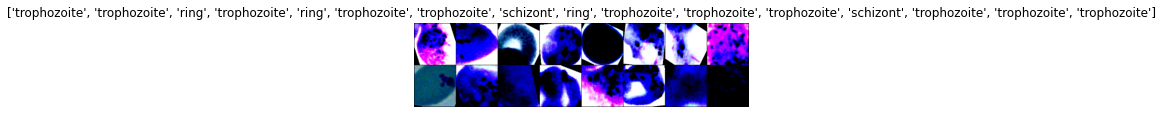

In [7]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

inputs, classes = next(iter(validloader))
show_databatch(inputs, classes)

In [124]:
# Load VGG 16
alexnet = models.AlexNet(num_classes=len(class_names))
print(alexnet)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [146]:
Epochs = 20
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(alexnet.parameters(), lr=0.001, momentum=0.9)

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [147]:
#losses = []
#acc = []
correct = 0
n = len(train_data)

from tqdm import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
alexnet.to(device)

for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
    
        outputs = alexnet(inputs)               
        loss = criterion(outputs, labels)   
        loss.backward()                     
        optimizer.step()                    

      
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).float().sum().item()

        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.data))

    acc.append(100 * correct / n) 
    losses.append(running_loss/len(trainloader))
    correct = 0
    torch.save(alexnet.state_dict(), '/content/drive/My Drive/Colab Notebooks/mcc_alexnet.pth')

print('Finished Training')


0it [00:00, ?it/s]
Train Epoch: 0 [64/2702 (2%)]	Loss: 0.661105: : 2it [00:09,  4.90s/it]
Train Epoch: 0 [588/2702 (98%)]	Loss: 0.510882: : 43it [00:12,  3.52it/s]
Train Epoch: 1 [588/2702 (98%)]	Loss: 0.569299: : 43it [00:12,  3.38it/s]
Train Epoch: 2 [588/2702 (98%)]	Loss: 0.666936: : 43it [00:12,  3.40it/s]
Train Epoch: 3 [588/2702 (98%)]	Loss: 1.170225: : 43it [00:13,  3.27it/s]
Train Epoch: 4 [588/2702 (98%)]	Loss: 0.335611: : 43it [00:12,  3.31it/s]
Train Epoch: 5 [588/2702 (98%)]	Loss: 0.307702: : 43it [00:12,  3.38it/s]
Train Epoch: 6 [588/2702 (98%)]	Loss: 0.702220: : 43it [00:12,  3.43it/s]
Train Epoch: 7 [588/2702 (98%)]	Loss: 0.482889: : 43it [00:12,  3.33it/s]
Train Epoch: 8 [588/2702 (98%)]	Loss: 0.795872: : 43it [00:12,  3.36it/s]
Train Epoch: 9 [588/2702 (98%)]	Loss: 0.839879: : 43it [00:12,  3.41it/s]
Train Epoch: 10 [588/2702 (98%)]	Loss: 0.801360: : 43it [00:13,  3.29it/s]
Train Epoch: 11 [588/2702 (98%)]	Loss: 0.834366: : 43it [00:12,  3.35it/s]
Train Epoch: 12 [58

Finished Training


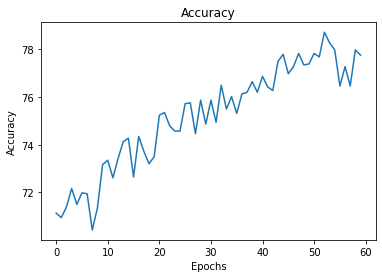

In [148]:
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot(acc)

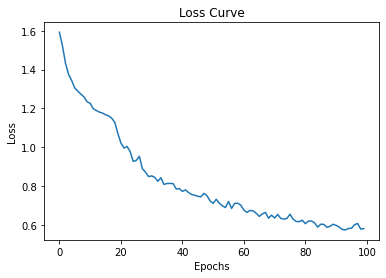

In [149]:
plt.title("Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(losses)

In [16]:
def Accuracy(network ,dataset):
  correct = 0
  total = 0
  inx = 0 
  
  with torch.no_grad():
    for data in dataset:

        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = network(images)
        _, predicted = torch.max(outputs.data, 1)

        inx += 1
        print("\r Iterating on image batches : ",inx,end="")
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
  return (100*correct/total)

In [150]:
acc_ = Accuracy(alexnet,trainloader)
print("\nTraining Accuracy %d %%" % acc_)

 Iterating on image batches :  43
Training Accuracy 79 %


In [156]:
acc_ = Accuracy(alexnet,testloader)
print("\nTesting Accuracy %d %%" % acc_)

 Iterating on image batches :  22
Testing Accuracy 74 %


In [152]:
acc_ = Accuracy(alexnet,validloader)
print("\nValidation Accuracy %d %%" % acc_)

 Iterating on image batches :  21
Validation Accuracy 71 %


In [94]:
def ClassWise_Accuracy(network, dataset, class_labels):
  inx = 0 
  class_correct = list(0. for i in range(len(class_labels)))
  class_total = list(0. for i in range(len(class_labels)))
  
  with torch.no_grad():
    for data in dataset:
        images, lbl = data

        images, labels = images.to(device), lbl.to(device)
        outputs = network(images)
        
        _, predicted = torch.max(outputs.data, 1)
        
        for j in range(0,labels.size(0)):
          if (predicted[j]==lbl[j]):

            if (predicted[j] == 0): class_correct[0]+=1
            if (predicted[j] == 1): class_correct[1]+=1
            if (predicted[j] == 2): class_correct[2]+=1
            if (predicted[j] == 3): class_correct[3]+=1
            if (predicted[j] == 4): class_correct[4]+=1
              
          
          if (lbl[j] == 0): class_total[0]+=1
          if (lbl[j] == 1): class_total[1]+=1
          if (lbl[j] == 2): class_total[2]+=1
          if (lbl[j] == 3): class_total[3]+=1
          if (lbl[j] == 4): class_total[4]+=1

        inx += 1
        print("\r: ",inx,end="")
  print("\n")
  for i in range(len(class_labels)):
    print('Accuracy of %5s : %2d %%' % (class_labels[i], 100 * class_correct[i] / class_total[i]))
    print(class_labels[i],': ',class_correct[i],'/',class_total[i])

In [153]:
ClassWise_Accuracy(alexnet,trainloader,class_names)

:  43

Accuracy of gametocyte : 44 %
gametocyte :  118.0 / 268.0
Accuracy of leukocyte : 97 %
leukocyte :  200.0 / 206.0
Accuracy of  ring : 81 %
ring :  450.0 / 552.0
Accuracy of schizont : 68 %
schizont :  218.0 / 320.0
Accuracy of trophozoite : 85 %
trophozoite :  1160.0 / 1356.0


In [154]:
ClassWise_Accuracy(alexnet,validloader,class_names)

:  21

Accuracy of gametocyte : 21 %
gametocyte :  7.0 / 32.0
Accuracy of leukocyte : 95 %
leukocyte :  19.0 / 20.0
Accuracy of  ring : 71 %
ring :  49.0 / 69.0
Accuracy of schizont : 52 %
schizont :  21.0 / 40.0
Accuracy of trophozoite : 83 %
trophozoite :  141.0 / 169.0


In [155]:
ClassWise_Accuracy(alexnet,testloader,class_names)

:  22

Accuracy of gametocyte : 41 %
gametocyte :  15.0 / 36.0
Accuracy of leukocyte : 100 %
leukocyte :  22.0 / 22.0
Accuracy of  ring : 68 %
ring :  48.0 / 70.0
Accuracy of schizont : 54 %
schizont :  23.0 / 42.0
Accuracy of trophozoite : 81 %
trophozoite :  138.0 / 170.0


In [ ]:
#! python /content/flip_images.py